In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import warnings

from datetime import date, time, timedelta
import pendulum

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_recall_curve

In [2]:
data = pd.read_csv("./Data/fraudTest.csv")

In [3]:
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [5]:
data.is_fraud.value_counts(normalize= 1)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

In [6]:
columns_to_drop = ['cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'trans_num','lat','long','city_pop','merch_lat','merch_long','unix_time']
data = data.drop(columns=columns_to_drop, axis =1)

In [7]:
# # 2. Convert 'dob' to 'age'
# data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
# data['age'] = (pd.to_datetime('today') - data['dob']).dt.days // 365
# data = data.drop(columns=['dob'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   gender                 555719 non-null  object 
 6   job                    555719 non-null  object 
 7   dob                    555719 non-null  object 
 8   is_fraud               555719 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 38.2+ MB


In [8]:
data = data.drop(['Unnamed: 0'], axis =1)

In [9]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'],format='%Y-%m-%d %H:%M:%S')

data['hour'] = data['trans_date_trans_time'].dt.hour
data['day'] = data['trans_date_trans_time'].dt.day
data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek 
data['month'] = data['trans_date_trans_time'].dt.month
data['quarter'] = data['trans_date_trans_time'].dt.quarter
data.head()

,trans_date_trans_time,merchant,category,amt,gender,job,dob,is_fraud,hour,day,day_of_week,month,quarter
0,2020-06-21 12:14:25,fraud_Kirlin and Sons,personal_care,2.86,M,Mechanical engineer,1968-03-19,0,12,21,6,6,2
1,2020-06-21 12:14:33,fraud_Sporer-Keebler,personal_care,29.84,F,"Sales professional, IT",1990-01-17,0,12,21,6,6,2
2,2020-06-21 12:14:53,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,"Librarian, public",1970-10-21,0,12,21,6,6,2
3,2020-06-21 12:15:15,fraud_Haley Group,misc_pos,60.05,M,Set designer,1987-07-25,0,12,21,6,6,2
4,2020-06-21 12:15:17,fraud_Johnston-Casper,travel,3.19,M,Furniture designer,1955-07-06,0,12,21,6,6,2


In [10]:
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d')

current_date = pd.to_datetime('today')
data['age_cust'] = (current_date.year - data['dob'].dt.year).astype(int)

print(data[['dob', 'age_cust']])

              dob  age_cust
0      1968-03-19        56
1      1990-01-17        34
2      1970-10-21        54
3      1987-07-25        37
4      1955-07-06        69
...           ...       ...
555714 1966-02-13        58
555715 1999-12-27        25
555716 1981-11-29        43
555717 1965-12-15        59
555718 1993-05-10        31

[555719 rows x 2 columns]


In [11]:
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9] 

data['age_group'] = pd.cut(data['age_cust'], bins=bins, labels=labels, right=False)

data.head()

,trans_date_trans_time,merchant,category,amt,gender,job,dob,is_fraud,hour,day,day_of_week,month,quarter,age_cust,age_group
0,2020-06-21 12:14:25,fraud_Kirlin and Sons,personal_care,2.86,M,Mechanical engineer,1968-03-19,0,12,21,6,6,2,56,5
1,2020-06-21 12:14:33,fraud_Sporer-Keebler,personal_care,29.84,F,"Sales professional, IT",1990-01-17,0,12,21,6,6,2,34,3
2,2020-06-21 12:14:53,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,"Librarian, public",1970-10-21,0,12,21,6,6,2,54,5
3,2020-06-21 12:15:15,fraud_Haley Group,misc_pos,60.05,M,Set designer,1987-07-25,0,12,21,6,6,2,37,3
4,2020-06-21 12:15:17,fraud_Johnston-Casper,travel,3.19,M,Furniture designer,1955-07-06,0,12,21,6,6,2,69,6


In [12]:
num_bins = 300  

data['amt'] = pd.cut(data['amt'], bins=num_bins, labels=False, right=False)

data.head()

,trans_date_trans_time,merchant,category,amt,gender,job,dob,is_fraud,hour,day,day_of_week,month,quarter,age_cust,age_group
0,2020-06-21 12:14:25,fraud_Kirlin and Sons,personal_care,0,M,Mechanical engineer,1968-03-19,0,12,21,6,6,2,56,5
1,2020-06-21 12:14:33,fraud_Sporer-Keebler,personal_care,0,F,"Sales professional, IT",1990-01-17,0,12,21,6,6,2,34,3
2,2020-06-21 12:14:53,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,0,F,"Librarian, public",1970-10-21,0,12,21,6,6,2,54,5
3,2020-06-21 12:15:15,fraud_Haley Group,misc_pos,0,M,Set designer,1987-07-25,0,12,21,6,6,2,37,3
4,2020-06-21 12:15:17,fraud_Johnston-Casper,travel,0,M,Furniture designer,1955-07-06,0,12,21,6,6,2,69,6


In [13]:
# Display the duplicate rows
duplicates = data[data.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [trans_date_trans_time, merchant, category, amt, gender, job, dob, is_fraud, hour, day, day_of_week, month, quarter, age_cust, age_group]
Index: []


In [14]:
def clean_df(data):
    return data.drop(['trans_date_trans_time','dob','age_cust'],axis=1)

data = clean_df(data)

In [15]:
data['merchant'] = data['merchant'].apply(lambda x : x.replace('fraud_',''))
data[['merchant']].head()

,merchant
0,Kirlin and Sons
1,Sporer-Keebler
2,"Swaniawski, Nitzsche and Welch"
3,Haley Group
4,Johnston-Casper


In [16]:
encoder = LabelEncoder()

def encode(df3):
    data['merchant'] = encoder.fit_transform(data['merchant'])
    data['category'] = encoder.fit_transform(data['category'])
    data['job'] = encoder.fit_transform(data['job'])
    return data

data = encode(data)

data.head()

,merchant,category,amt,gender,job,is_fraud,hour,day,day_of_week,month,quarter,age_group
0,319,10,0,M,275,0,12,21,6,6,2,5
1,591,10,0,F,392,0,12,21,6,6,2,3
2,611,5,0,F,259,0,12,21,6,6,2,5
3,222,9,0,M,407,0,12,21,6,6,2,3
4,292,13,0,M,196,0,12,21,6,6,2,6


In [17]:
data = pd.get_dummies(data, columns=['gender'], prefix='gender')

data['gender_M'] = data['gender_M'].astype(int)
data['gender_F'] = data['gender_F'].astype(int)

data.head()

,merchant,category,amt,job,is_fraud,hour,day,day_of_week,month,quarter,age_group,gender_F,gender_M
0,319,10,0,275,0,12,21,6,6,2,5,0,1
1,591,10,0,392,0,12,21,6,6,2,3,1,0
2,611,5,0,259,0,12,21,6,6,2,5,1,0
3,222,9,0,407,0,12,21,6,6,2,3,0,1
4,292,13,0,196,0,12,21,6,6,2,6,0,1


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   merchant     555719 non-null  int32   
 1   category     555719 non-null  int32   
 2   amt          555719 non-null  int64   
 3   job          555719 non-null  int32   
 4   is_fraud     555719 non-null  int64   
 5   hour         555719 non-null  int32   
 6   day          555719 non-null  int32   
 7   day_of_week  555719 non-null  int32   
 8   month        555719 non-null  int32   
 9   quarter      555719 non-null  int32   
 10  age_group    555520 non-null  category
 11  gender_F     555719 non-null  int32   
 12  gender_M     555719 non-null  int32   
dtypes: category(1), int32(10), int64(2)
memory usage: 30.2 MB


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('is_fraud', axis=1), data['is_fraud'], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

rounded_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

accuracy = accuracy_score(y_test, rounded_predictions)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, rounded_predictions)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_test, rounded_predictions)
recall = recall_score(y_test, rounded_predictions)
f1 = f1_score(y_test, rounded_predictions)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

auc_roc = roc_auc_score(y_test, predictions)
print("AUC-ROC:", auc_roc)

print("First 10 Predictions:", rounded_predictions[:10])

Accuracy: 0.9961671345281796
Confusion Matrix:
[[110718      0]
 [   426      0]]


C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1-Score: 0.0
AUC-ROC: 0.5325163951186056
First 10 Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('is_fraud', axis=1), data['is_fraud'], test_size=0.2, random_state=42)

# Inicializando e treinando o modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)
score = cross_validate(model, X_train, y_train, cv = 5, return_train_score = True)

# Fazendo previsões no conjunto de teste
predictions = model.predict(X_test)

# Calculando métricas de avaliação
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
auc_roc = roc_auc_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC-ROC:", auc_roc)
print("Confusion Matrix:")
print(conf_matrix)

# Extraindo os coeficientes do modelo de regressão logística
coefficients = model.coef_

# Exibindo os coeficientes e as características correspondentes
feature_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients[0]})
print("Feature Coefficients:")
print(feature_coefficients)

# Adicionando as previsões ao DataFrame de teste
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_is_fraud'] = predictions

# Exibindo as características e as previsões
print("Features and Predicted is_fraud:")
print(X_test_with_predictions)

Accuracy: 0.004174764269776146
Precision: 0.003825244815668203
Recall: 0.9976525821596244
F1-Score: 0.0076212678203174036
AUC-ROC: 0.4990024142034235
Confusion Matrix:
[[    39 110679]
 [     1    425]]
Feature Coefficients:
        Feature   Coefficient
0      merchant -2.911634e-30
1      category -5.282859e-32
2           amt -3.993661e-33
3           job -2.051041e-30
4          hour -1.085950e-31
5           day -1.396892e-31
6   day_of_week -2.308268e-32
7         month -8.067519e-32
8       quarter -2.928814e-32
9     age_group  3.511382e-19
10     gender_F -4.654710e-33
11     gender_M -3.826778e-33
Features and Predicted is_fraud:
        merchant  category  amt  job  hour  day  day_of_week  month  quarter  \
119106        17        12    0  258     7    2            6      8        3   
179292       529         7    1  192    14   23            6      8        3   
540729        45         7    0  109    16   28            0     12        4   
374360        99         2    0 

In [21]:
result =  pd.DataFrame(score)

In [22]:
print(result)

   fit_time  score_time  test_score  train_score
0  2.306651    0.044197    0.004184     0.004201
1  2.441514    0.050072    0.004206     0.004195
2  2.412190    0.051430    0.004173     0.004203
3  2.457455    0.046091    0.004229     0.004189
4  2.479453    0.038056    0.004195     0.004198


In [23]:
result.test_score.mean()

0.0041972670528032385

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

tp = float(conf_matrix[1][1])
tn = float(conf_matrix[0][0])
fp = float(conf_matrix[0][1])
fn = float(conf_matrix[1][0])

print(classification_report(y_train, model.predict(X_train)))

spec = tn/(tn+fp)
sens = tp/(tp+fp)

g_mean = (spec*sens)**(0.5)

print(f"G-mean: {g_mean}")

              precision    recall  f1-score   support

           0       0.96      0.00      0.00    442856
           1       0.00      1.00      0.01      1719

    accuracy                           0.00    444575
   macro avg       0.48      0.50      0.00    444575
weighted avg       0.96      0.00      0.00    444575

G-mean: 0.0011607877200535475


In [25]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state =0)
x_resampled, y_resampled = rus.fit_resample(X_train,y_train)
print(x_resampled.shape)

(3438, 12)


In [26]:
print(y_resampled[y_resampled == 1].shape, y_resampled[y_resampled ==0].shape)

(1719,) (1719,)


In [28]:
mets = ["f1", "precision","recall","accuracy"]
score_run = cross_validate(model, x_resampled, y_resampled, cv = 5, return_train_score=True, scoring=mets)

In [29]:
pd.DataFrame(score_run)

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,0.046993,0.029000,0.011561,0.005801,1.0,1.0,0.005814,0.002909,0.502907,0.501455
1,0.042498,0.027543,0.005797,0.007246,1.0,1.0,0.002907,0.003636,0.501453,0.501818
2,0.056999,0.021851,0.005797,0.007246,1.0,1.0,0.002907,0.003636,0.501453,0.501818
3,0.029877,0.030369,0.005814,0.007241,1.0,1.0,0.002915,0.003634,0.502183,0.501636
4,0.043494,0.027336,0.005797,0.007246,1.0,1.0,0.002907,0.003636,0.500728,0.501999


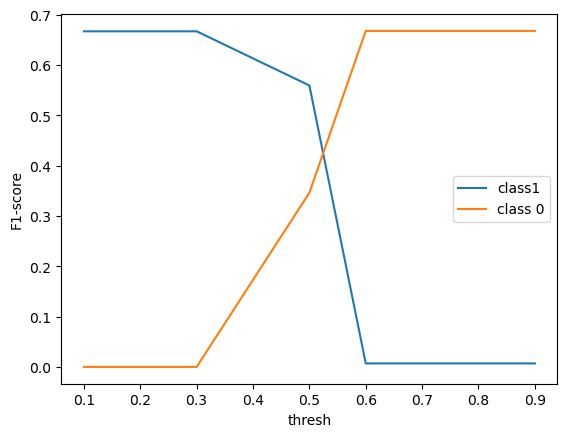

In [31]:
model.fit(x_resampled, y_resampled)
prob = model.predict_proba(x_resampled)[:,1]

f1_0 = []
f1_1 = []

thresh = [0.9, 0.8,0.6,0.5,0.3,0.2,0.1]
for i in thresh:
    preds = np.where(prob >= i,1,0)
    
    f1_0.append(f1_score(y_resampled, preds, pos_label = 0))
    f1_1.append(f1_score(y_resampled, preds))
    
plt.plot(thresh, f1_1)
plt.plot(thresh, f1_0)
plt.ylabel("F1-score")
plt.xlabel("thresh")
plt.legend(["class1", "class 0"])
plt.show()


In [30]:
test_prob = model.predict_proba(X_test)[:,1]
preds = np.where(test_prob>0.4,1,0)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.00      0.00    110718
           1       0.00      1.00      0.01       426

    accuracy                           0.00    111144
   macro avg       0.49      0.50      0.00    111144
weighted avg       0.97      0.00      0.00    111144



# Oversampling

In [34]:
from imblearn.under_sampling import TomekLinks
from collections import Counter


tom = TomekLinks()
x_tom, y_tom = tom.fit_resample(X_train, y_train)

print('Resampled dataset shape {}'.format(Counter(y_tom)))

Resampled dataset shape Counter({0: 442418, 1: 1719})


In [37]:
score_tom = cross_validate(model, x_tom, y_tom , cv = 5, return_train_score = True, scoring = mets)
pd.DataFrame(score_tom)

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,2.167955,0.247621,0.007673,0.007690,0.003852,0.003860,0.994186,0.997091,0.004188,0.004196
1,4.428576,0.253671,0.007696,0.007685,0.003863,0.003857,0.997093,0.996364,0.004210,0.004191
2,2.233295,0.241487,0.007673,0.007690,0.003851,0.003860,0.997085,0.996366,0.004165,0.004202
3,2.525603,0.243877,0.007696,0.007685,0.003863,0.003857,0.997093,0.996364,0.004210,0.004191
4,2.135357,0.239244,0.007696,0.007685,0.003863,0.003857,0.997093,0.996364,0.004199,0.004194


In [42]:
model.fit(x_tom, y_tom)
print(classification_report(y_tom, model.predict(x_tom)))

              precision    recall  f1-score   support

           0       0.96      0.00      0.00    442418
           1       0.00      1.00      0.01      1719

    accuracy                           0.00    444137
   macro avg       0.48      0.50      0.00    444137
weighted avg       0.96      0.00      0.00    444137



In [43]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.00      0.00    110718
           1       0.00      1.00      0.01       426

    accuracy                           0.00    111144
   macro avg       0.49      0.50      0.00    111144
weighted avg       0.97      0.00      0.00    111144



In [47]:
from imblearn.over_sampling import SMOTE

smt = SMOTE()
x_sm, y_sm = smt.fit_resample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_sm)))


Resampled dataset shape Counter({0: 442856, 1: 442856})


In [50]:
 score_sm = cross_validate(model, x_sm, y_sm , cv = 5, return_train_score = True, scoring = mets)

In [51]:
pd.DataFrame(score_sm)

,fit_time,score_time,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_accuracy,train_accuracy
0,3.713340,0.499640,0.006996,0.006940,0.909357,0.910029,0.003511,0.003483,0.501583,0.501569
1,3.796451,0.488991,0.006928,0.006956,0.908555,0.910228,0.003477,0.003492,0.501561,0.501574
2,5.666616,0.490452,0.007242,0.006878,0.920000,0.907270,0.003636,0.003452,0.501660,0.501550
3,3.997056,0.480134,0.006682,0.007018,0.900000,0.912281,0.003353,0.003523,0.501490,0.501592
4,4.544952,0.489154,0.006906,0.006962,0.910979,0.909625,0.003466,0.003494,0.501564,0.501574


In [53]:
model.fit(x_sm, y_sm)

LogisticRegression()

In [54]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.03      0.00      0.00       426

    accuracy                           1.00    111144
   macro avg       0.51      0.50      0.50    111144
weighted avg       0.99      1.00      0.99    111144



Duplicates found in column: merchant
Duplicates found in column: category
Duplicates found in column: amt
Duplicates found in column: gender
Duplicates found in column: city
Duplicates found in column: state
Duplicates found in column: zip
Duplicates found in column: lat
Duplicates found in column: long
Duplicates found in column: city_pop
Duplicates found in column: job
Duplicates found in column: dob
Duplicates found in column: is_fraud


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Columns: 537 entries, merchant to job_Writer
dtypes: float64(530), int64(4), object(3)
memory usage: 2.2+ GB


merchant                         693
category                          14
amt                            37256
city                             849
zip                              912
                               ...  
job_Water engineer                 2
job_Water quality scientist        2
job_Web designer                   2
job_Wellsite geologist             2
job_Writer                         2
Length: 537, dtype: int64

In [12]:
if data.shape[0] == data.drop_duplicates().shape[0]:
    print('No Duplicates Found')
else:
    duplicates = data.shape[0] - data.drop_duplicates().shape[0]
    print('{} duplicats found'.format(duplicates))

87 duplicats found


In [16]:
X = data.drop("is_fraud", axis = 1)
y = data["is_fraud"]

In [17]:
le = LabelEncoder()
X['city'] = le.fit_transform(X['city'])
X['category'] = le.fit_transform(X['category'])
y = le.fit_transform(y)

In [18]:
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1, stratify = y)

In [19]:
# Apply Target Encoding to 'merchant' and 'category'
target_encoder = ce.TargetEncoder(cols=['merchant', 'category'])
X[['merchant', 'category']] = target_encoder.fit_transform(X[['merchant', 'category']],y )

In [17]:
# 6. Initialize and apply TargetEncoder




In [20]:
# Fit on training data and transform
X_train_encoded = target_encoder.fit_transform(X_train, y_train)

# Transform test data
X_test_encoded = target_encoder.transform(X_test)

In [21]:
# 7. (Optional) Handle any remaining missing values
# For example, you can fill them with the median or mean
X_train_encoded = X_train_encoded.fillna(X_train_encoded.median())
X_test_encoded = X_test_encoded.fillna(X_train_encoded.median())

# 8. (Optional) Scale numerical features if needed
from sklearn.preprocessing import StandardScaler

numeric_cols = ['amt', 'lat', 'long', 'city_pop', 'age']
scaler = StandardScaler()

X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

# Now, X_train_encoded and X_test_encoded are ready for modeling

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444575 entries, 473964 to 209728
Columns: 536 entries, merchant to job_Writer
dtypes: float64(530), int32(2), int64(3), object(1)
memory usage: 1.8+ GB


In [24]:
# Identify the object (categorical) columns
object_columns = X_train.select_dtypes(include=['object']).columns
print(object_columns)

Index(['merchant'], dtype='object')


In [25]:
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Continue with cross-validation
model = LogisticRegression()
scores = cross_validate(model, X_train_encoded, y_train, cv=5, return_train_score=True)

C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [ ]:
model = LogisticRegression(max_iter=1000)  # Try a larger number like 1000
scores = cross_validate(model, X_train_encoded, y_train, cv=5, return_train_score=True)

In [21]:
model = LogisticRegression()
scores = cross_validate(model, X_train, y_train, cv = 5, return_train_score = True)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'fraud_Morissette-Schaefer'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1201, in fit
    X, y = self._validate_data(
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\Ishita Bhojani\anaconda3\lib\site-packages\pandas\core\generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'fraud_Kuhn LLC'


In [25]:
X_train.shape

(444575, 20)

In [27]:
# Fit and transform the training data, transform the test data
X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

In [28]:
X_train_encoded.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat
473964,2020-12-14 02:31:49,377234009633447,0.005776,0.004107,18.12,Theresa,Blackwell,0.003815,43576 Kristina Islands,0.000000,0.000000,25442,39.3716,-77.8229,1925,0.008371,1966-02-14,acd1043bc0545204db28db17eef40ae4,1386988309,39.908673
317924,2020-10-20 03:32:58,213148039875802,0.008929,0.009746,13.41,Jill,Jacobs,0.003815,034 Kimberly Mountains,0.000000,0.002756,33510,27.9551,-82.2966,79613,0.004321,1978-11-30,903f96df77f3e9a387aa57894d942cb4,1382239978,28.107770
178147,2020-08-23 04:39:16,2252055259910912,0.003576,0.009286,98.94,Jason,Hernandez,0.003914,220 Frank Gardens,0.000000,0.005055,54441,44.6437,-90.1031,828,0.000000,1991-08-19,7f01cba6cbe82880ab11ecf1d8091a9d,1377232756,44.699682
355590,2020-11-05 22:55:34,3551217896304745,0.003273,0.001906,6.81,Sara,Harris,0.003815,597 Jenny Ford Apt. 543,0.000000,0.004709,12986,44.2320,-74.4905,6120,0.005193,1976-10-09,81a59f0cf1138e49a889b9de09965933,1383692134,43.775011
10102,2020-06-24 01:51:57,376012912828093,0.003233,0.002760,40.12,Nathan,Mayer,0.003914,478 Donovan Corners Apt. 803,0.018817,0.004167,60193,42.0144,-88.0935,92294,0.004169,1969-05-01,9c4fff6725e462d09960d737be9886f9,1372038717,41.661821
